In [5]:
# This script loads images from girder, tracks nuclei, and saves the tracks back to girder as annotations.
# each frame gets a track up to that time.
# TODO: Save a single track used by all frames.

from __future__ import division, print_function
from ipywidgets import interact, interactive, fixed, interact_manual    
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy as sp
from scipy import ndimage
from IPython.core.debugger import set_trace
import cv2
import sys
from pprint import pprint
from random import randint
from nuclei.foci import *
import nuclei.girder as g
import nuclei.girder.time_lapse_data as reader

plt.rcParams['image.cmap'] = 'gist_earth'
matplotlib.rcParams['figure.figsize'] = (11.0, 11.0)


# input parameters
czi_folder_id = "5ae21cc31fbb9052b6669e58"
series_idx = 0


In [6]:
# Setup the reader.
source = reader.time_lapse_data()
source.load(czi_folder_id) 


In [3]:
def generate_tracks(source, series_idx):
    num_time_steps = source.get_series_length(series_idx)
    im, item_obj = source.get_image(series_idx,0)
    # detect rows of circles.
    rows = compute_rows(im)
    # draw the row as a santity check
    #for row in rows:
    #    cv2.line(im,(10,int(10*row[0]+row[1])),(2000,int(2000*row[0]+row[1])),(255,0,0),5)
    # We could upload this image as a ssanity check the rows were detected ok.

    if rows == None or len(rows) != 3:
        print("Could not find rows")
        return
    
    prev_frame_ellipses = None
    # union of all lines from all frames.
    # this will be an array of lines.  A line will be an array of points.  a point will be 3 (int, int, int)
    tracks = []
    # Save the image ids so we can upload the tracks to girder
    item_ids = []

    # Chain the lein segments so we get "polylines" as a series of points in arrays
    img1, img_info = source.get_image(series_idx,0)
    item_ids.append(img_info['_id'])
    img_bw = img1.copy()
    img_bw[:,:,0] = np.maximum(img1[:,:,1], img1[:,:,2])
    img_bw[:,:,1] = img_bw[:,:,0]
    img_bw[:,:,2] = img_bw[:,:,0]
    img1 = img_bw
    print(img1.shape)
    ellipses1 = find_cell_ellipses(img1)
    for t in range(1,num_time_steps):
        img2, img_info = source.get_image(series_idx, t)
        item_ids.append(img_info['_id'])
        img_bw = img2.copy()
        img_bw[:,:,0] = np.maximum(img2[:,:,1], img2[:,:,2])
        img_bw[:,:,1] = img_bw[:,:,0]
        img_bw[:,:,2] = img_bw[:,:,0]
        img2 = img_bw
        ellipses2 = find_cell_ellipses(img2)
        ellipse_pairs = match_ellipses(ellipses1, ellipses2, rows)
    
        # lnsegs are the line segments we want to add to our poly lines.
        for pair in ellipse_pairs:
            track = find_track_that_ends_with_ellipse(tracks, pair[0])
            if not track:
                # The line doe not exist. This is the first line segment.
                # make a line wit a single point (the start)
                track = Track()
                track.add_ellipse(pair[0], t-1)
                tracks.append(track)
            # We found the line that ends with the new segment's first point.
            # Add the second point to the line
            track.add_ellipse(pair[1], t)
        img1 = img2
        ellipses1 = ellipses2

    # we could upload this image as a sanity check tracks were reasonable.
    #tmp = img2.copy()
    #for track in tracks:
    #    track.draw_in_frame(tmp, num_time_steps)
    #plt.imshow(tmp)
    
    #print(len(tracks))
    combined_tracks = []
    while len(tracks) > 0:
        # Either we are finished merging track 1, or it gets merged with track2.
        # Either way, it is removed from the list of tracks.
        track1 = tracks.pop()
        track2 = find_best_track_to_merge(track1, tracks, rows)
        if track2 == None:
            combined_tracks.append(track1)
        else:
            #print("====== merge %s"%track2.get_hex_color())
            #track1.p()
            #track2.p()
            track2.merge_track(track1)

    #print(len(combined_tracks))
    #print(len(item_ids))
    #print(len(combined_tracks))
    saved_tracks = combined_tracks
    
    # Save the tracks to the stack in the series folder.
    folder = source.get_series_folder(series_idx)
    g.upload_tracks_to_stack(combined_tracks, folder['_id'])
    

In [4]:
num_series = source.get_number_of_series()
for idx in range(6, num_series):
    print('series %d'%idx)
    generate_tracks(source, idx)

series 6
Could not find rows
series 7
(2048, 2048, 3)
series 8
(2048, 2048, 3)
series 9
Could not find rows
series 10
(2048, 2048, 3)
series 11
(2048, 2048, 3)
series 12
(2048, 2048, 3)
series 13
Could not find rows
series 14
(2048, 2048, 3)
series 15
(2048, 2048, 3)
series 16
Could not find rows
series 17
(2048, 2048, 3)
series 18
(2048, 2048, 3)
series 19
(2048, 2048, 3)
series 20
Could not find rows
series 21
(2048, 2048, 3)
series 22
(2048, 2048, 3)
series 23
Could not find rows
series 24
(2048, 2048, 3)
series 25
(2048, 2048, 3)
series 26
(2048, 2048, 3)
series 27
Could not find rows


In [ ]:
# ====================================================================================
# The rest of this notebook, steps through generation of a single series.
# Each series takes a good time to process so if the above loop and function works
# then it is preferable. However the single pass would still be good for debugging.

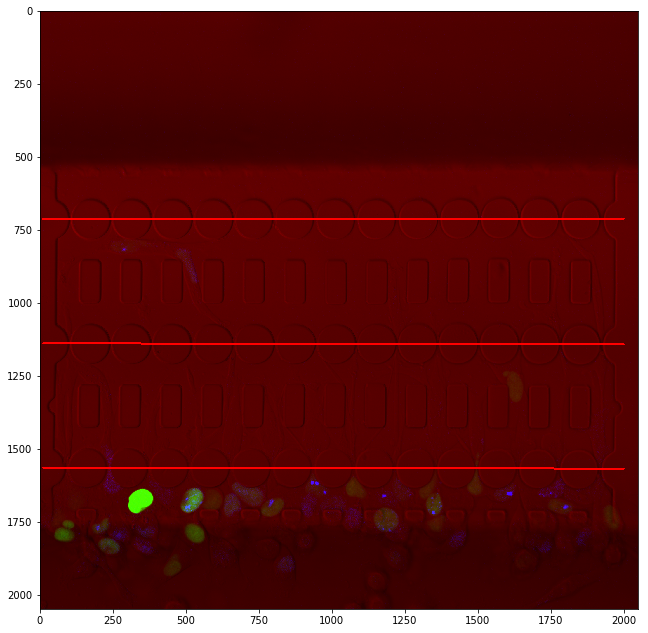

In [7]:
# This block sets up the reader of a czi folder.
# it then detects rows in the brightfield channel of an image.
series_idx = 10

num_time_steps = source.get_series_length(series_idx)
im, item_obj = source.get_image(series_idx,0)

# detect rows of circles.
rows = compute_rows(im)

# draw the row as a santity check
for row in rows:
    cv2.line(im,(10,int(10*row[0]+row[1])),(2000,int(2000*row[0]+row[1])),(255,0,0),5)

plt.imshow(im)


(2048, 2048, 3)


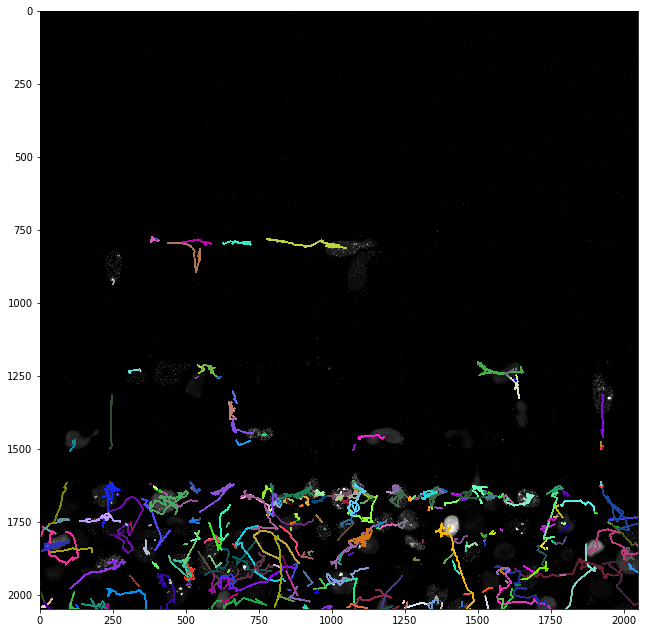

In [8]:
prev_frame_ellipses = None
# union of all lines from all frames.
# this will be an array of lines.  A line will be an array of points.  a point will be 3 (int, int, int)
tracks = []
# Save the image ids so we can upload the tracks to girder
item_ids = []

# Chain the lein segments so we get "polylines" as a series of points in arrays
img1, img_info = source.get_image(series_idx,0)
item_ids.append(img_info['_id'])
img_bw = img1.copy()
img_bw[:,:,0] = np.maximum(img1[:,:,1], img1[:,:,2])
img_bw[:,:,1] = img_bw[:,:,0]
img_bw[:,:,2] = img_bw[:,:,0]
img1 = img_bw
print(img1.shape)
ellipses1 = find_cell_ellipses(img1)
for t in range(1,num_time_steps):
    img2, img_info = source.get_image(series_idx, t)
    item_ids.append(img_info['_id'])
    img_bw = img2.copy()
    img_bw[:,:,0] = np.maximum(img2[:,:,1], img2[:,:,2])
    img_bw[:,:,1] = img_bw[:,:,0]
    img_bw[:,:,2] = img_bw[:,:,0]
    img2 = img_bw
    ellipses2 = find_cell_ellipses(img2)
    ellipse_pairs = match_ellipses(ellipses1, ellipses2, rows)
    
    # lnsegs are the line segments we want to add to our poly lines.
    for pair in ellipse_pairs:
        track = find_track_that_ends_with_ellipse(tracks, pair[0])
        if not track:
            # The line doe not exist. This is the first line segment.
            # make a line wit a single point (the start)
            track = Track()
            track.add_ellipse(pair[0], t-1)
            tracks.append(track)
        # We found the line that ends with the new segment's first point.
        # Add the second point to the line
        track.add_ellipse(pair[1], t)
    img1 = img2
    ellipses1 = ellipses2

tmp = img2.copy()
for track in tracks:
    track.draw_in_frame(tmp, num_time_steps)
plt.imshow(tmp)

In [4]:
print(len(tracks))
combined_tracks = []
while len(tracks) > 0:
    # Either we are finished merging track 1, or it gets merged with track2.
    # Either way, it is removed from the list of tracks.
    track1 = tracks.pop()
    track2 = find_best_track_to_merge(track1, tracks, rows)
    if track2 == None:
        combined_tracks.append(track1)
    else:
        #print("====== merge %s"%track2.get_hex_color())
        #track1.p()
        #track2.p()
        track2.merge_track(track1)

print(len(combined_tracks))
print(len(item_ids))

print(len(combined_tracks))
saved_tracks = combined_tracks

192
52
99
52


In [5]:
# Save the tracks to the stack in the series folder.
folder = source.get_series_folder(series_idx)
g.upload_tracks_to_stack(combined_tracks, folder['_id'])

In [ ]:
# save the tracks to the individual images.
#g.upload_tracks(combined_tracks, item_ids)

In [10]:
# this block is legacy code to make a video

def make_ellipse_mask(ellipse, time, gc, folder_id):
    img, item_obj = source.get_image(series_idx,time)
    black_img = np.zeros(img.shape, dtype=np.uint8)
    cv2.ellipse(black_img, ellipse, (1,1,1), -1)
    return(black_img)

# This function writes out images for training.
def save_tracking_video_frames(combined_tracks, source, series_idx, out_dir):
    for track in combined_tracks:
        for time in range(track.get_start_time()+1,track.get_end_time()):
            print(time)
            currentimg, _ = source.get_image(series_idx,time)
            previmg, _ = source.get_image(series_idx,time-1)
            prevellipse = track.get_ellipse_from_time(time-1)
            if prevellipse != None:
                # This uses data dir it will not work.
                # TODO: fix it.
                prevellipsemask = make_ellipse_mask(prevellipse,time-1,data_dir)
                centx = int(prevellipse[0][0])
                centy = int(prevellipse[0][1])
                croppedcurrent = currentimg[centy-150:centy+150, centx-150:centx+150, :]
                croppedprev = previmg[centy-150:centy+150, centx-150:centx+150, :]
                croppedmask = prevellipsemask[centy-150:centy+150, centx-150:centx+150, :]
                cv2.imwrite(out_dir + "channel1time%dcurrent.png"%time, croppedcurrent)
                cv2.imwrite(out_dir + "channel1time%dprev.png"%time, croppedprev)
                cv2.imwrite(out_dir + "channel1time%dprevmask.png"%time, croppedmask)


        


In [4]:
import sys
sys.version

'3.5.2 (default, Nov 23 2017, 16:37:01) \n[GCC 5.4.0 20160609]'